In [2]:
!wget http://www.lawrence.edu/fast/greggj/CMSC490/github.zip
!unzip github.zip

URL transformed to HTTPS due to an HSTS policy
--2023-10-18 18:28:37--  https://www.lawrence.edu/fast/greggj/CMSC490/github.zip
Resolving www.lawrence.edu (www.lawrence.edu)... 143.44.124.14
Connecting to www.lawrence.edu (www.lawrence.edu)|143.44.124.14|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www7.lawrence.edu/fast/greggj/CMSC490/github.zip [following]
--2023-10-18 18:28:37--  https://www7.lawrence.edu/fast/greggj/CMSC490/github.zip
Resolving www7.lawrence.edu (www7.lawrence.edu)... 143.44.124.14
Connecting to www7.lawrence.edu (www7.lawrence.edu)|143.44.124.14|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.lawrence.edu/fast/greggj/CMSC490/github.zip [following]


--2023-10-18 18:28:37--  https://www2.lawrence.edu/fast/greggj/CMSC490/github.zip
Resolving www2.lawrence.edu (www2.lawrence.edu)... 143.44.124.14
Connecting to www2.lawrence.edu (www2.lawrence.edu)|143.44.124.14|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www2.lawrence.edu/fast/GREGGJ/CMSC490/github.zip [following]
--2023-10-18 18:28:37--  http://www2.lawrence.edu/fast/GREGGJ/CMSC490/github.zip
Connecting to www2.lawrence.edu (www2.lawrence.edu)|143.44.124.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103105294 (98M) [application/zip]
Saving to: ‘github.zip.2’

github.zip.2        100%[===================>]  98.33M  69.7MB/s    in 1.4s    

2023-10-18 18:28:39 (69.7 MB/s) - ‘github.zip.2’ saved [103105294/103105294]

Archive:  github.zip
replace embold_test.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
from tokenizers import BertWordPieceTokenizer
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader


import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-10-18 19:36:22.489860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 19:36:22.671139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 19:36:22.671171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 19:36:22.672117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
data_frame = pd.read_json('embold_train.json')
train_df= pd.read_json("embold_train.json").reset_index(drop=True)
train_df.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [4]:
test_df= pd.read_json("embold_test.json").reset_index(drop=True)
test_df.head()

,title,body
0,config question path-specific environment var...,issue description or question\r \r hey @artemg...
1,crash indien vol,de simulator crasht als hij vol zit
2,unable to mine rocks,"sarkasmo starting today, when i hit enter act..."
3,not all whitelists are processed,create following rules... order of creation is...
4,add ctx menu for idafree 70 and idafree 5,"associated with .dll, .dll_, .exe, .exe_, .sc,..."


In [5]:
train_ex_df= pd.read_json("embold_train_extra.json").reset_index(drop=True)
train_ex_df.head()

,title,body,label
0,use a 8bit typeface,since this is meant to emulate some old arcade...,1
1,implement wireless m-bus binding,_from chris.pa...@googlemail.com https://cod...,1
2,add multilang support for timeago.js,currently it is only en . \r required to add ...,1
3,scaleway - seg-fault on shutdown,tbr irc creates a new scaleway instance with...,0
4,sistema de pintura: no se guardar los nuevos p...,este sp ya estaba asignado a un carro y se enc...,0


In [6]:
def dataset_length_check(data_frame):
    print(len(data_frame),data_frame.index.shape[-1])
                 
dataset_length_check(train_df)
dataset_length_check(train_ex_df)
dataset_length_check(test_df)

150000 150000
300000 300000
30000 30000


In [7]:
data_frame = pd.concat([train_df,train_ex_df],ignore_index=True)
data_frame.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [8]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   450000 non-null  object
 1   body    450000 non-null  object
 2   label   450000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


Total Counts of label column: 
 1    207318
0    200481
2     42201
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

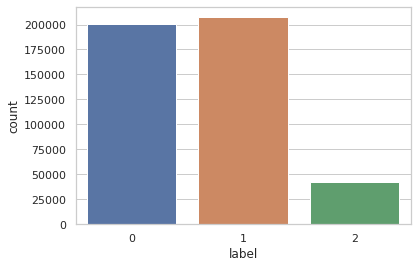

In [9]:
print('Total Counts of label column: \n'.format(),data_frame['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=data_frame)

In [10]:
df_bug = data_frame[data_frame['label']==0]
df_feature = data_frame[data_frame['label']==1]
df_question = data_frame[data_frame['label']==2]

In [11]:
label_counts = data_frame.label.value_counts().sort_index()
label_counts

0    200481
1    207318
2     42201
Name: label, dtype: int64

In [12]:
def fx(x):
    return x['title'] + " " + x['body']   
data_frame['text']= data_frame.apply(lambda x : fx(x),axis=1)
data_frame['text']= data_frame.apply(lambda x : fx(x),axis=1)

In [13]:
print('Number of datapoints with label as Bug :',label_counts[0])
print('Number of datapoints with label as Feature :',label_counts[1])
print('Number of datapoints with label as Question :',label_counts[2])

Number of datapoints with label as Bug : 200481
Number of datapoints with label as Feature : 207318
Number of datapoints with label as Question : 42201


In [14]:
import nltk
import re
import string


def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [15]:
from string import punctuation
from nltk.corpus import stopwords

def remove_stopwords(git_text):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_git_text

In [16]:
from collections import Counter

def visulize_dataset(data_frame, category):
    
    # Let's apply the above two functions 'clean_text' and 'remove_stopwords' to the whole dataset

    data_frame['text'] = data_frame['text'].apply(lambda x: x.replace("\\r", ""))
    data_frame['text'] = data_frame['text'].apply(lambda x: clean_text(x))
    data_frame["text"] = data_frame["text"].apply(remove_stopwords)
    

In [17]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
data_frame['text'] = data_frame['text'].apply(lambda x: x.replace("\\r", ""))
data_frame['text'] = data_frame['text'].apply(lambda x: clean_text(x))
data_frame.head()

,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,yzoom piano roll a yzoom on the piano roll wou...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,auto update feature hi great job so far saenz...
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on pid off alarm actions for expe...


In [18]:
data_frame.head()
data_frame.describe

<bound method NDFrame.describe of                                                     title  \
0                                       y-zoom piano roll   
1                             buggy behavior in selection   
2                                     auto update feature   
3                      filter out noisy endpoints in logs   
4       enable pid on / pid off alarm actions for ardu...   
...                                                   ...   
449995                       shield against invalid dates   
449996                                     fix the knight   
449997  portaudio playback binding crashes often, ubun...   
449998  add --db-path option for allowing user to spec...   
449999                 staff users cannot log in to admin   

                                                     body  label  \
0             a y-zoom on the piano roll would be useful.      1   
1       ! screenshot from 2016-02-23 21 27 40  https:/...      0   
2       hi,\r \r great job so

In [19]:
X = data_frame['text'].to_numpy()
Y = data_frame['label'].to_numpy()

X.shape




(450000,)

In [20]:
Y.shape

(450000,)

In [21]:
x_train = X[:270000]
x_validation = X[270000:360000]
x_test = X[360000:]
y_train = Y[:270000]
y_validation = Y[270000:360000]
y_test = Y[360000:]

In [22]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [23]:
#making the datasets
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)
validation_ds = tf.data.Dataset.from_tensor_slices((x_validation,y_validation)).batch(64)


2023-10-18 19:37:05.952109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 19:37:05.955618: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [24]:
#do text vectorization
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    max_tokens=10000,
    output_mode="multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = validation_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [25]:
from tensorflow import keras
import keras.api._v2.keras as keras
from keras import layers

def get_model(max_tokens=10000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [26]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 160067 (625.26 KB)
Trainable params: 160067 (625.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


1986/4219 [=============>................] - ETA: 4s - loss: 0.6931 - accuracy: 0.7409

: 